In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(4)

Autosaving every 600 seconds


# Conditional Neural Process 1D - Sinusoisals

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a **Conditional** Neural Process for a simple class of 1D functions. The functions are defined by $f(x) = a * sin(x - b)$ where $a$ and $b$ and randomly sampled.

**Credits**: the task, visualisation and notebook structure are taken from (although without latent): https://github.com/EmilienDupont/neural-processes


In [3]:
from skssl.transformers import NeuralProcessLoss, NeuralProcess
from skssl.predefined import MLP
from skssl.training.helpers import context_target_split

from ntbks_datasets import SineDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 50
num_context = 4
num_target = 4
batch_size = 2

def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=2)

def get_cntxt_trgt(*args):
    return context_target_split(*args, 
                                range_cntxts=(num_context, num_context), 
                                range_extra_trgts=(num_target, num_target))

neural_proc = NeuralProcess(x_dim, y_dim,
                            Encoder=_DeepMLP,
                            Decoder=_DeepMLP,
                            r_dim=r_dim,
                            get_cntxt_trgt=get_cntxt_trgt)

##  Data

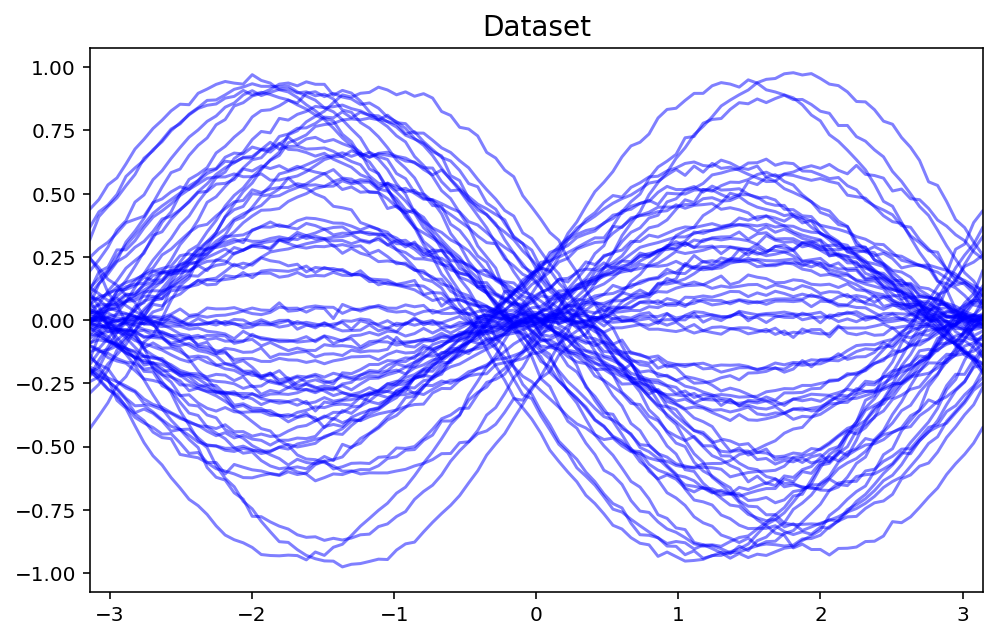

In [5]:
dataset = SineDataset(num_samples=2000)
plot_dataset_samples(dataset)

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

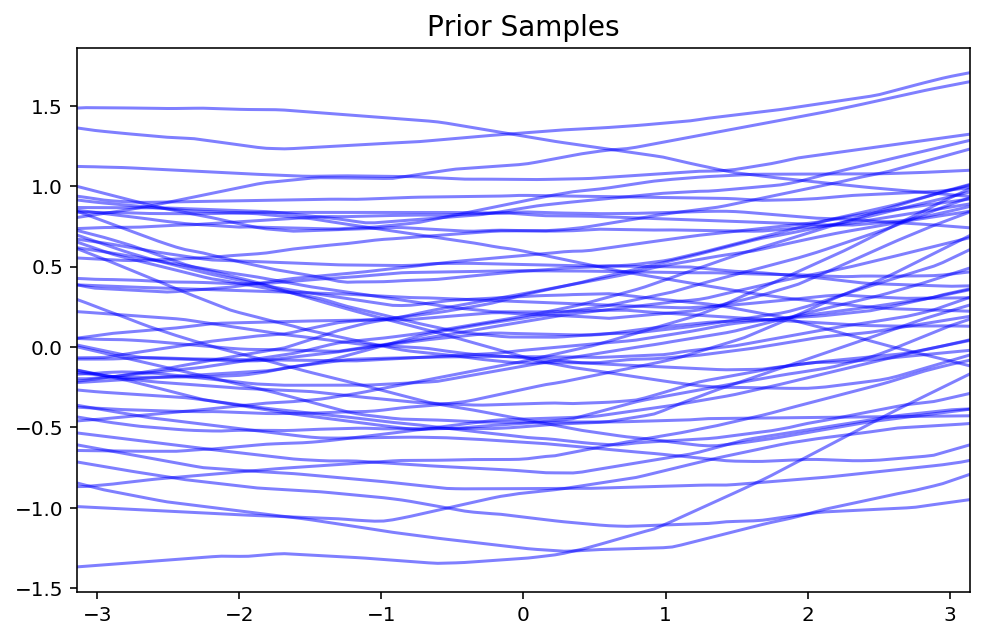

In [7]:
plot_prior_samples(neural_proc, r_dim)

## Training

In [8]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                             max_epochs=30,
                            batch_size=batch_size)

In [9]:
_=model.fit(*make_Xy_input(dataset))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.9805       -1.1581  2.4139


      2       -0.8763       -2.2245  1.8925


      3       -2.5909       -2.5382  2.3855


      4       -3.8987       -5.8857  2.3580


      5       -5.2377       -4.8711  2.7168


      6       -5.5477       -6.1730  2.6371


      7       -5.9814       -3.7441  2.5641


      8       -6.2135       -6.8967  2.3037


      9       -6.0776       -6.7701  2.4576


     10       -6.4435       -5.5680  2.5045


     11       -6.5402       -6.6273  1.9949


     12       -7.0217       -4.6898  2.3852


     13       -6.7578       -8.4245  2.3060


     14       -7.3136       -7.3384  2.4389


     15       -7.1128       -7.2583  2.3826


     16       -7.2951       -8.4841  2.4411


     17       -7.1869       -5.8252  2.1136


     18       -7.4508       -7.6888  1.9789


     19       -7.5635       -6.9855  1.9887


     20       -7.3992       -7.6249  1.9789


     21       -7.7478       -8.3208  2.1805


     22       -7.5402       -7.0706  2.4551


     23       -7.7005       -8.2408  2.4617


     24       -7.5931       -8.9079  2.6103


     25       -7.6786       -7.6932  2.5692


     26       -8.0352       -8.4007  2.6649


     27       -8.0918       -7.2671  2.4980


     28       -7.7857       -8.7633  2.1638


     29       -7.9895       -8.2717  2.4580


     30       -8.1600       -8.3369  2.5407


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

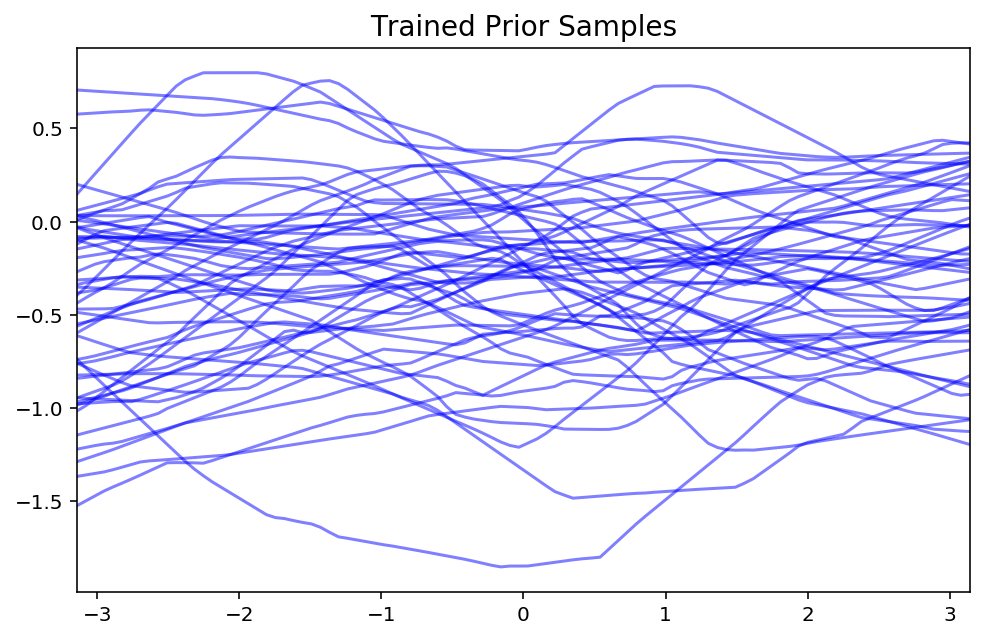

In [10]:
plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples")

## Posterior

std: 0.100503616


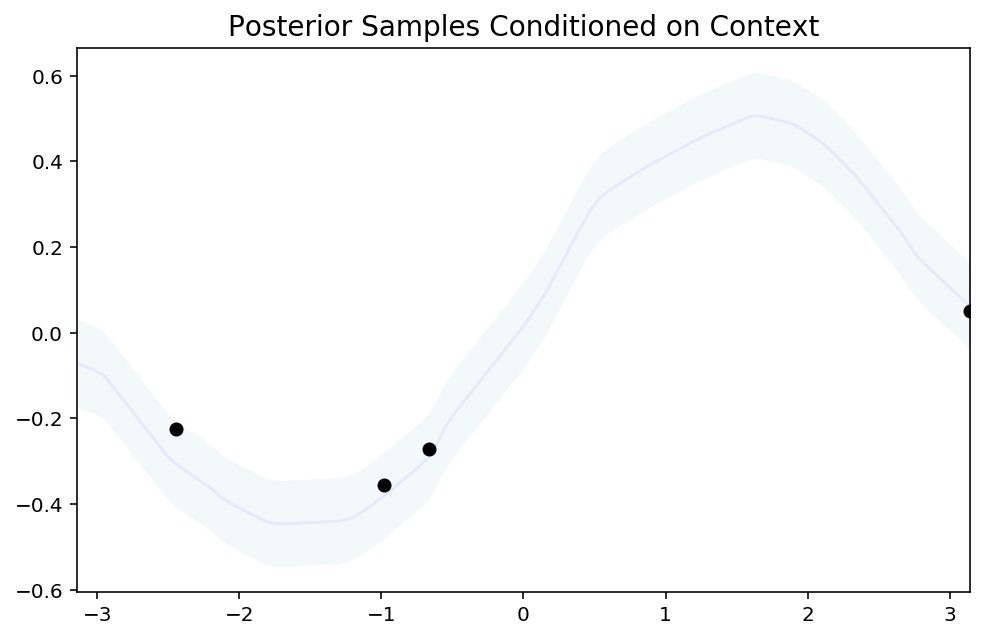

In [12]:
for X, Y in model.get_iterator(dataset, training=False):
    break
    
X_cntxt, Y_cntxt, _, _ = context_target_split(X[0:1], Y[0:1], 
                                range_cntxts=(4, 4))

plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, is_plot_std=True, n_samples=1)

Note that with conditional neural processes it is **not** possible to sample multiple function as done eith the neural processes. All I can show is the mean and variance it predicts, but as we see the variance seems to be uniform, it doesn't even decrease at context points. This is because of the the mean aggreagation function which means that the network doesn't know where the context points were.

The standard deviation actually collapses to 0.1, and this is because this is the minimum value we let it have. So it seems that it the output variance is useless.